<a href="https://colab.research.google.com/github/poomwarawat/Thesis_image_processing/blob/master/ProvinceNeighbor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.optimizers import Adam, RMSprop
from tqdm import tqdm
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

In [2]:
img_width, img_height = 128, 128

In [3]:
train_data_dir = "/content/drive/My Drive/Thesis/data/test"
validation_data_dir = "/content/drive/My Drive/Thesis/data/validation"

In [4]:
def load_data(dir_path, img_size=(128,128)):    
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):                
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)    
    return X, y, labels

In [5]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [7]:
IMG_SIZE = (128, 128)
X_train, y_train, labels = load_data("/content/drive/My Drive/Thesis/data/test/", IMG_SIZE)
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_val, y_val, _ = load_data("/content/drive/My Drive/Thesis/data/validation/", IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

100%|██████████| 2/2 [01:26<00:00, 43.00s/it]


In [8]:
datagen = ImageDataGenerator(rescale=1./255)

In [9]:
import os
os.chdir("/content/drive/My Drive/Thesis/data/test")
!ls

no  yes


In [10]:
RANDOM_SEED = 123

In [11]:
train_generator = datagen.flow_from_directory( # ตรงนี้จะสร้างออปเจ็คไว้เทรน
        train_data_dir,
        color_mode='rgb',
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary',
        seed=RANDOM_SEED
)

validation_generator = datagen.flow_from_directory( # ตรงนี้จะสร้างออปเจ็คไว้ validation
        validation_data_dir,
        color_mode='rgb',
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='binary',
        seed=RANDOM_SEED
)

Found 250 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [12]:
vgg_weight_path = "/content/drive/My Drive/Thesis/data/base_model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(
    weights=vgg_weight_path,
    include_top=False, 
    input_shape=(128, 128) + (3,)
)

In [13]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='relu'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 14,722,881
Trainable params: 8,193
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [15]:
nb_epoch = 10 #จำนวน epoch คือรอบที่จะทำให้ Model วิวัฒฯ(ผมไม่รู้ว่าศัพท์ไทยเรียกว่าอะไรครับ)ขึ้นไปเรื่อง
nb_train_samples = 250 #จำนวน sample ที่นำมาเทรน
nb_validation_samples = 125 #จำนวน sample ที่นำมา validate
BS = 32

In [16]:
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

In [20]:
history =  model.fit_generator(
    train_generator, 
    steps_per_epoch=int(nb_train_samples / BS), 
    epochs=100,
    validation_data=validation_generator, 
    validation_steps=int(nb_validation_samples / BS),
    callbacks=[es],
    verbose= 1,
    workers= 3,
    max_queue_size= 8
)


Epoch 1/100
7/7 [==============================] - 1s 80ms/step - loss: 0.8492 - accuracy: 0.9174 - val_loss: 0.6553 - val_accuracy: 0.9375
Epoch 2/100
7/7 [==============================] - 1s 74ms/step - loss: 1.0966 - accuracy: 0.8807 - val_loss: 0.4381 - val_accuracy: 0.9167
Epoch 3/100
7/7 [==============================] - 1s 77ms/step - loss: 0.8616 - accuracy: 0.9037 - val_loss: 0.6498 - val_accuracy: 0.9583
Epoch 4/100
7/7 [==============================] - 1s 75ms/step - loss: 0.5730 - accuracy: 0.9174 - val_loss: 0.3268 - val_accuracy: 0.9792
Epoch 5/100
7/7 [==============================] - 1s 77ms/step - loss: 1.4390 - accuracy: 0.8624 - val_loss: 0.6826 - val_accuracy: 0.9167
Epoch 6/100
7/7 [==============================] - 1s 75ms/step - loss: 0.9624 - accuracy: 0.8945 - val_loss: 1.0196 - val_accuracy: 0.9167
Epoch 7/100
7/7 [==============================] - 1s 79ms/step - loss: 0.7867 - accuracy: 0.9128 - val_loss: 0.6740 - val_accuracy: 0.9583
Epoch 8/100
7/7 [===

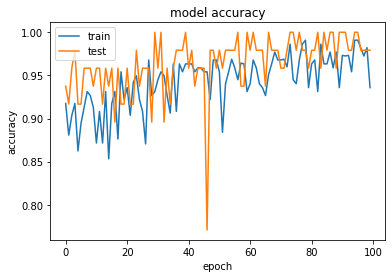

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.84


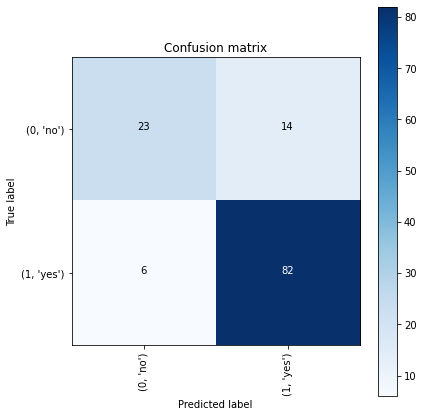

In [28]:
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [30]:
len(predictions)

125

In [31]:
predictions

[1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0]